# Fit Real Data with Basic SIR Model

**Author: Veronica Scerra**  
**Last Updated: 2025-10-15**

**Purpose:**
Fit SIR to OWID daily incidence for one country

**Inputs & Dependencies:**
- Code: `src/dataio/load_owid_covid.py`, `src/epimodels/sir.py`, `src/epimodels/fitting.py`
- Libraries: `numpy`, `matplotlib`, `pandas`  
- Covid19 data pulled from OWID

**Outputs:**
- Fill in once you're done with this notebook
**Context:**
Fourth notebook in the **SIR Model Project**, serving as a means for applying the SIR model fitting to a slice of real world data.

### Import paths and dependencies

In [1]:
import sys, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join("..", "src")))
from dataio.loaders import load_owid_covid
from epimodels.fitting import fit_beta_gamma

### Load data from one country

In [2]:
country = "United States"
df = load_owid_covid(country, source="compact", start="2020-03-01", end="2021-06-01", smooth=7)
df.head(), df.tail(), df.shape

(        date  t  incidence  incidence_smooth   population
 0 2020-03-01  0        4.0         11.857143  341534041.0
 1 2020-03-02  1        9.0         18.571429  341534041.0
 2 2020-03-03  2       18.0         27.428571  341534041.0
 3 2020-03-04  3       35.0         37.857143  341534041.0
 4 2020-03-05  4       51.0         55.857143  341534041.0,
           date    t  incidence  incidence_smooth   population
 453 2021-05-28  453    23475.0      20173.571429  341534041.0
 454 2021-05-29  454    21970.0      19647.857143  341534041.0
 455 2021-05-30  455    24780.0      18883.142857  341534041.0
 456 2021-05-31  456    15628.0      16649.428571  341534041.0
 457 2021-06-01  457    12350.0      15588.428571  341534041.0,
 (458, 5))

### Choose the observed series and model grid

In [3]:
# observed series (incidence with light smoothing)
y_obs = df["incidence_smooth"].to_numpy()
t = df["t"].to_numpy().astype(float)
N = int(df["population"].iloc[0])

# initial infected guess (small, >0)
I0 = max(10, int(0.0005 * N)) # you can tune this if you like

# Bounds: infectious period 5-14 days -> gamma in [1/14, 1/5]
beta_bounds = (0.05, 0.8)
gamma_bounds = (1/14, 1/5)

### Fit $\beta$, $\gamma$ (observable = incidence)

In [4]:
res = fit_beta_gamma(
    t=t, 
    y_obs=y_obs,
    N=N,
    I0=I0,
    R0_init=0,
    observable="incidence",
    beta_bounds=beta_bounds,
    gamma_bounds=gamma_bounds,
    grid_size=(25, 25),
    refine=True,
    init_step=(0.02, 0.02),
    random_restarts=3
)

res

{'beta': 0.11250000000000196,
 'gamma': 0.09821428571428571,
 'R0': 1.1454545454545655,
 'loss': 1452877215.3989189,
 'scale': 0.45525687527383485,
 'y_fit': array([     0.        ,   8803.92983956,   8929.53405292,   9056.86432272,
          9185.94244458,   9316.7904327 ,   9449.43052014,   9583.88515938,
          9720.17702252,   9858.32900152,   9998.36420847,  10140.30597557,
         10284.17785522,  10430.00361989,  10577.80726213,  10727.61299408,
         10879.44524746,  11033.32867292,  11189.2881396 ,  11347.34873459,
         11507.53576216,  11669.87474295,  11834.39141302,  12001.11172295,
         12170.06183653,  12341.26812955,  12514.75718841,  12690.55580862,
         12868.6909931 ,  13049.18995043,  13232.08009289,  13417.38903441,
         13605.14458836,  13795.37476509,  13988.10776952,  14183.3719984 ,
         14381.19603739,  14581.60865814,  14784.63881504,  14990.31564171,
         15198.66844772,  15409.72671446,  15623.52009156,  15840.07839242,
       

### Plot fit vs. data

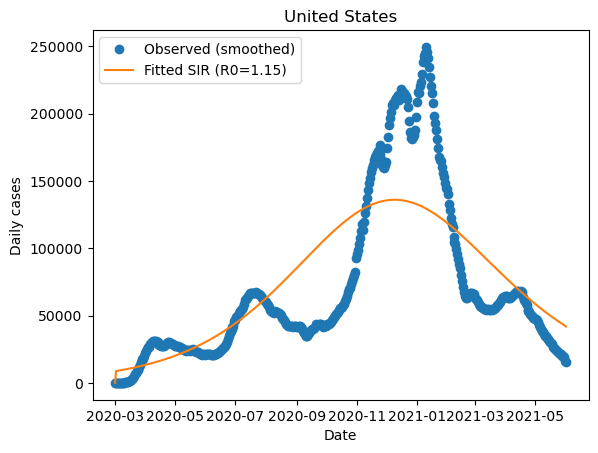

In [5]:
plt.figure()
plt.plot(df["date"], y_obs, marker='o', linestyle='', label='Observed (smoothed)')
plt.plot(df["date"], res["y_fit"], label=f"Fitted SIR (R0={res['R0']:.2f})")
plt.ylabel("Daily cases"); plt.xlabel("Date"); plt.legend(); plt.title(country)
plt.show()

### Inspect trajectories at fitted params

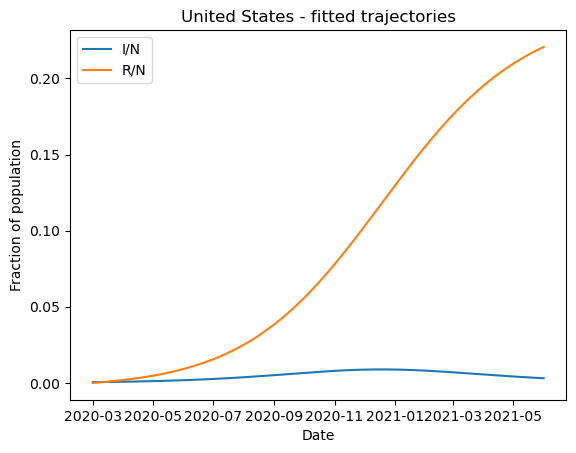

In [6]:
sim = res['sim']
plt.figure()
plt.plot(df["date"], sim["I"]/N, label="I/N")
plt.plot(df["date"], sim["R"]/N, label="R/N")
plt.ylabel("Fraction of population"); plt.xlabel("Date"); plt.legend()
plt.title(f"{country} - fitted trajectories")
plt.show()

### Assess fit

In [7]:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_obs, res["y_fit"])
peak_day_err = df.loc[np.argmax(y_obs), "date"] - df.loc[np.argmax(res["y_fit"]), "date"]
print(f"RMSE: {rmse:,.1f}  |  Peak day error: {peak_day_err}")


RMSE: 38,116.6  |  Peak day error: 32 days 00:00:00


## Refit the data with piecewise beta values to reflect varying transmission rates

In [16]:
from epimodels.fitting import fit_piecewise_beta

# build segments by date
breaks = ["2020-03-01", "2020-06-01", "2020-10-01", "2021-03-01", "2021-06-01"] #start...end
edges = df.set_index("date").index.astype("datetime64[ns]")

# convert to t-units
edge_vals = [float(df.loc[df["date"] >= np.datetime64(d)].iloc[0]["t"]) for d in breaks]
# ensure unique and sorted; also ensure first/last match window
edge_vals[0] = float(df["t"].iloc[0])
edge_vals[-1] = float(df["t"].iloc[-1])
edges_t = np.array(edge_vals, dtype=float)

y_obs = df["incidence_smooth"].to_numpy()
t = df["t"].astype(float).to_numpy()
N = int(df["population"].iloc[0])
I0 = max(10, int(0.0005 * N))

res_pw = fit_piecewise_beta(
   t=t, y_obs=y_obs, N=N, I0=I0,
    edges=edges_t,
    observable="incidence",
    beta_bounds=(0.05, 1.2),
    gamma_bounds=(1/14, 1/5),
    lambda_smooth=0.0,      # try 1e-3 to discourage big jumps
    grid_gamma=15,
    step_beta=0.03,
    step_gamma=0.01
)
res_pw

{'betas': array([0.251875, 0.20125 , 0.380625, 0.75375 ]),
 'gamma': 0.2,
 'R0_segments': array([1.259375, 1.00625 , 1.903125, 3.76875 ]),
 'loss': 2900584987.7504377,
 'scale': 0.08768717668956656,
 'y_fit': array([     0.        ,   3868.6823881 ,   4073.47944163,   4288.94067092,
          4515.60202004,   4754.02424684,   5004.79383608,   5268.52391854,
          5545.85519209,   5837.45684055,   6144.02744491,   6466.29588129,
          6805.02219889,   7160.99847053,   7535.0496074 ,   7928.03412859,
          8340.84487491,   8774.40965533,   9229.69181315,   9707.69069751,
         10209.44202449,  10736.01811055,  11288.52795928,  11868.11718073,
         12475.96772086,  13113.29737665,  13781.35907039,  14481.43985484,
         15214.85961865,  15982.9694595 ,  16787.14969023,  17628.80744131,
         18509.37382094,  19430.30059223,  20393.05632528,  21399.12198056,
         22449.98587875,  23547.13801161,  24692.06364787,  25886.23618878,
         27131.10922861,  28428.

### Plot the piecewise fit

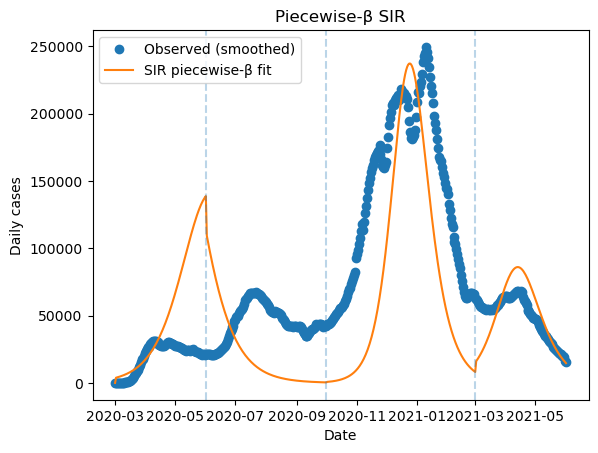

Segment R0 values: [1.26 1.01 1.9  3.77]


In [17]:
plt.figure()
plt.plot(df["date"], y_obs, marker='o', linestyle='', label="Observed (smoothed)")
plt.plot(df["date"], res_pw["y_fit"], label="SIR piecewise-β fit")
for x in res_pw["edges"][1:-1]:  # vertical lines at internal boundaries
    plt.axvline(df.loc[df["t"]==x, "date"].iloc[0], alpha=0.3, linestyle="--")
plt.ylabel("Daily cases"); plt.xlabel("Date"); plt.legend(); plt.title("Piecewise-β SIR")
plt.show()

print("Segment R0 values:", np.round(res_pw["R0_segments"], 2))